In [1]:
# Define your test parameters
test_id = "Test_000"
n_qubits = 7
n_a_qubits = 2
q_depth = 6
n_generators = 2
lrG = 0.5
lrD = 0.01
batch_size = 1
num_samples = 512
n_epochs = 2
y = 0.4

In [2]:
markdown_content = f"""
# qGAN Individual Test Specification

## General Information
- **Test ID**: {test_id}
- **Date**: YYYY-MM-DD
- **Description**: Brief description of the test objectives and setup.

### **Training dataset features**
| Parameter            | Value  |
|----------------------|--------|
| Resolution     | 8x8       |
| Interpolation  | Sumpool   |
| Channel        | Tracks      |
| Transformation | None      |

### **Quantum Circuit Parameters**
| Parameter            | Value  |
|----------------------|--------|
| Number of Qubits     | {n_qubits}      |
| Number of Auxiliary Qubits | {n_a_qubits}      |
| Circuit Depth        | {q_depth}      |
| output transf denominator | {y}        |

### **GAN Parameters**
| Parameter            | Value  |
|----------------------|--------|
| Number of Generators | {n_generators}      |
| Generator Learning Rate  | {lrG} |
| Discriminator Learning Rate  | {lrD} |
| Batch Size           | {batch_size}     |
| Number of Samples    | {num_samples}   |
| Number of epochs     | {n_epochs} |

## Hardware and Software
- **Hardware used**: CPU AMD Ryzen 5 5600G
- **Framework**: Pytorch and Pennylane

## Observations
- Detailed observations about the test, including any anomalies, special conditions, or notable behaviors.
"""

from IPython.display import Markdown, display

display(Markdown(markdown_content))




# qGAN Individual Test Specification

## General Information
- **Test ID**: Test_000
- **Date**: YYYY-MM-DD
- **Description**: Brief description of the test objectives and setup.

### **Training dataset features**
| Parameter            | Value  |
|----------------------|--------|
| Resolution     | 8x8       |
| Interpolation  | Sumpool   |
| Channel        | Tracks      |
| Transformation | None      |

### **Quantum Circuit Parameters**
| Parameter            | Value  |
|----------------------|--------|
| Number of Qubits     | 7      |
| Number of Auxiliary Qubits | 2      |
| Circuit Depth        | 6      |
| output transf denominator | 0.4        |

### **GAN Parameters**
| Parameter            | Value  |
|----------------------|--------|
| Number of Generators | 2      |
| Generator Learning Rate  | 0.5 |
| Discriminator Learning Rate  | 0.01 |
| Batch Size           | 1     |
| Number of Samples    | 512   |
| Number of epochs     | 2 |

## Hardware and Software
- **Hardware used**: CPU AMD Ryzen 5 5600G
- **Framework**: Pytorch and Pennylane

## Observations
- Detailed observations about the test, including any anomalies, special conditions, or notable behaviors.


### **Libraries**

In [3]:
# Library imports
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import pennylane as qml
import h5py

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from python_package.metrics import FID, relative_entropy
from IPython.display import clear_output
from itertools import product



# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# **Sum pooled jets**

In [4]:
with h5py.File("/home/reyguadarrama/GSoC/data/gluon_data/gluon_tracks_sumpool_8x8.h5", 'r') as file:
    all_gluon_8x8 = file['gluon_tracks_sumpool_8x8'][:num_samples]

In [5]:
gluon_tracks_overlay = np.mean(all_gluon_8x8, axis=0)
total_energy = np.sum(all_gluon_8x8, axis=(1,2))
particles_energy_deposits = all_gluon_8x8[all_gluon_8x8 > 0]

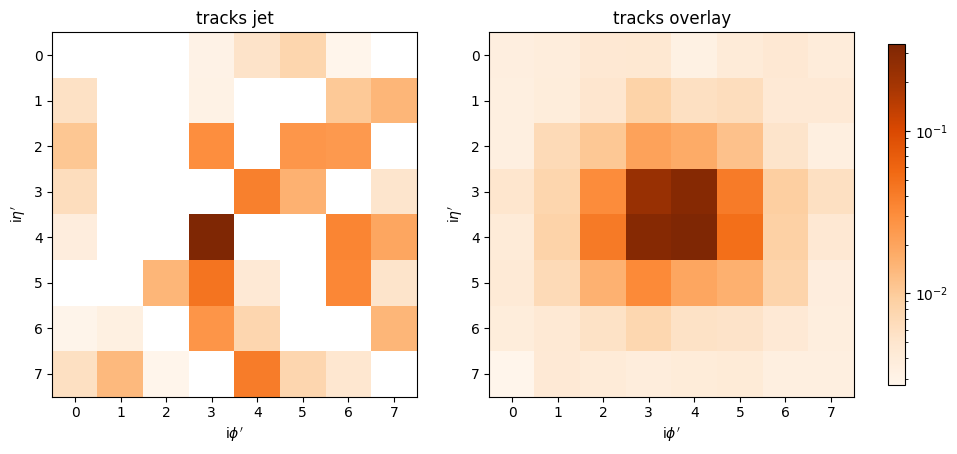

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

im1 = axs[0].imshow(all_gluon_8x8[0], cmap="Oranges", norm=mcolors.LogNorm())
axs[0].set_title("tracks jet")

axs[1].imshow(gluon_tracks_overlay, cmap="Oranges", norm=mcolors.LogNorm())
axs[1].set_title("tracks overlay")

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()

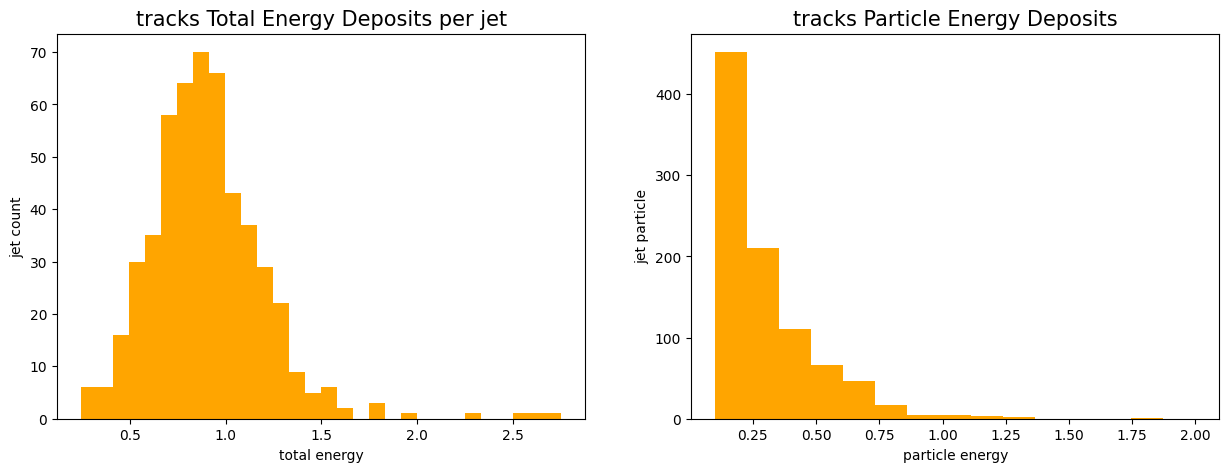

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(total_energy, bins=30, color="orange")
axs[0].set_title("tracks Total Energy Deposits per jet", fontsize=15)
axs[0].set_xlabel("total energy")
axs[0].set_ylabel("jet count")

axs[1].hist(particles_energy_deposits, range=(0.1, 2), bins=15, color="orange")
axs[1].set_title("tracks Particle Energy Deposits", fontsize=15)
axs[1].set_xlabel("particle energy")
axs[1].set_ylabel("jet particle")

plt.show()

# **Training**

In [8]:
class QuarkDataset(Dataset):
    def __init__(self, image):
        self.data = torch.tensor(image, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [9]:
# Create the data loader instance
dataset = QuarkDataset(all_gluon_8x8.reshape(num_samples, 64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(64, 128),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(128, 32),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="backprop")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits, 3)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for q in range(n_qubits):
            qml.RX(weights[i][q][0], wires=q)
            qml.RY(weights[i][q][1], wires=q)
            qml.RZ(weights[i][q][2], wires=q)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        qml.CZ(wires=[n_qubits - 1, 0])

    return qml.probs(wires=list(range(n_qubits)))

In [12]:
weights = torch.rand(n_qubits*q_depth*3)
noise = torch.rand(8, n_qubits, device=device) * np.pi / 2

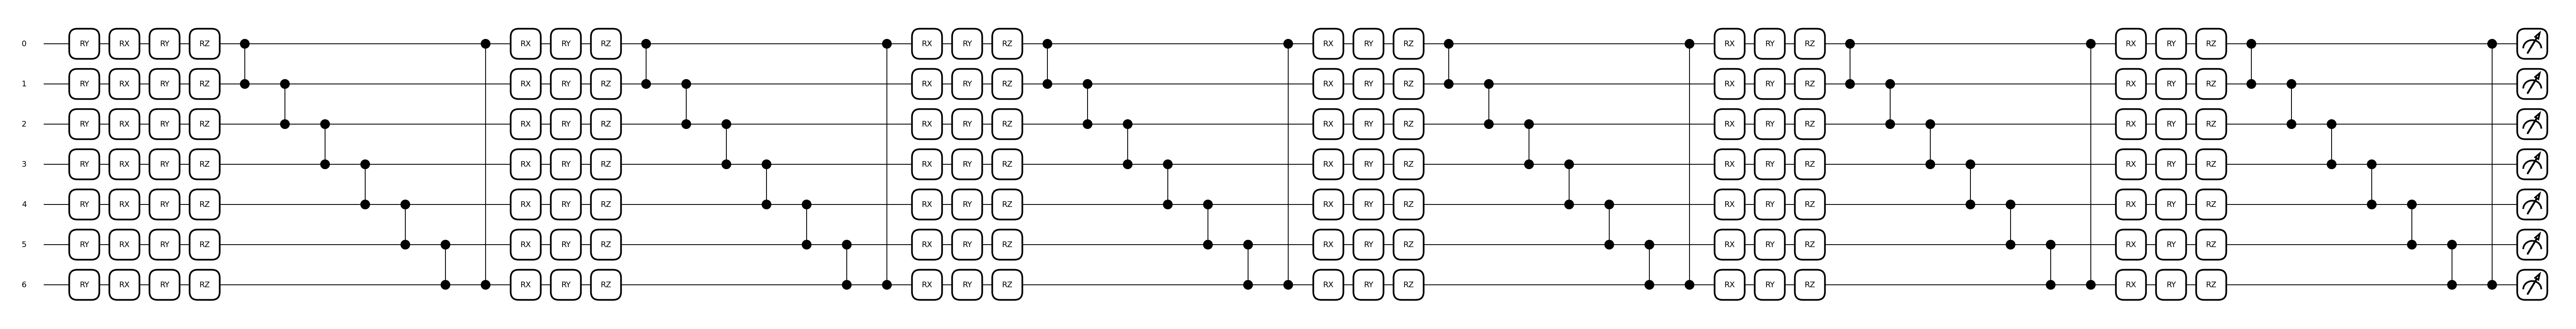

In [13]:
qml.draw_mpl(quantum_circuit)(noise, weights)
plt.show()

In [14]:
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    #probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / y#2*torch.max(probsgiven0)
    return probsgiven

In [15]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()


        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits * 3), requires_grad=True)
                for _ in range(n_generators)
            ]
        )

        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)
            


        return images 

In [16]:
def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(rel_entr) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

    # Metric 1
    ax1.set_title("RMSE", fontsize=15)
    ax1.plot(epochs, rel_entr, color="darkorange", linewidth=3)
    ax1.set_xlabel("Epoch")
    ax1.set_yscale("log")
    ax1.grid()

    # Metric 2
    ax2.set_title("FID", fontsize=15)
    ax2.plot(epochs, fid, color="orange", linewidth=3)
    ax2.set_xlabel("Epoch")
    ax2.set_yscale("log")
    ax2.grid()

    # Generated distribution
    im = ax3.imshow(gen_tracks_overlay, cmap='Oranges', aspect='auto', norm=mcolors.LogNorm())
    ax3.set_title('Generated tracks overlay', fontsize=15)

    fig.colorbar(im, ax=ax3)

    plt.suptitle(f"Epoch {counter}", fontsize=25)
    plt.show()

In [17]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# plot lists
rel_entr = []
fid = []
epochs = []
disc_loss = []
gen_loss = []


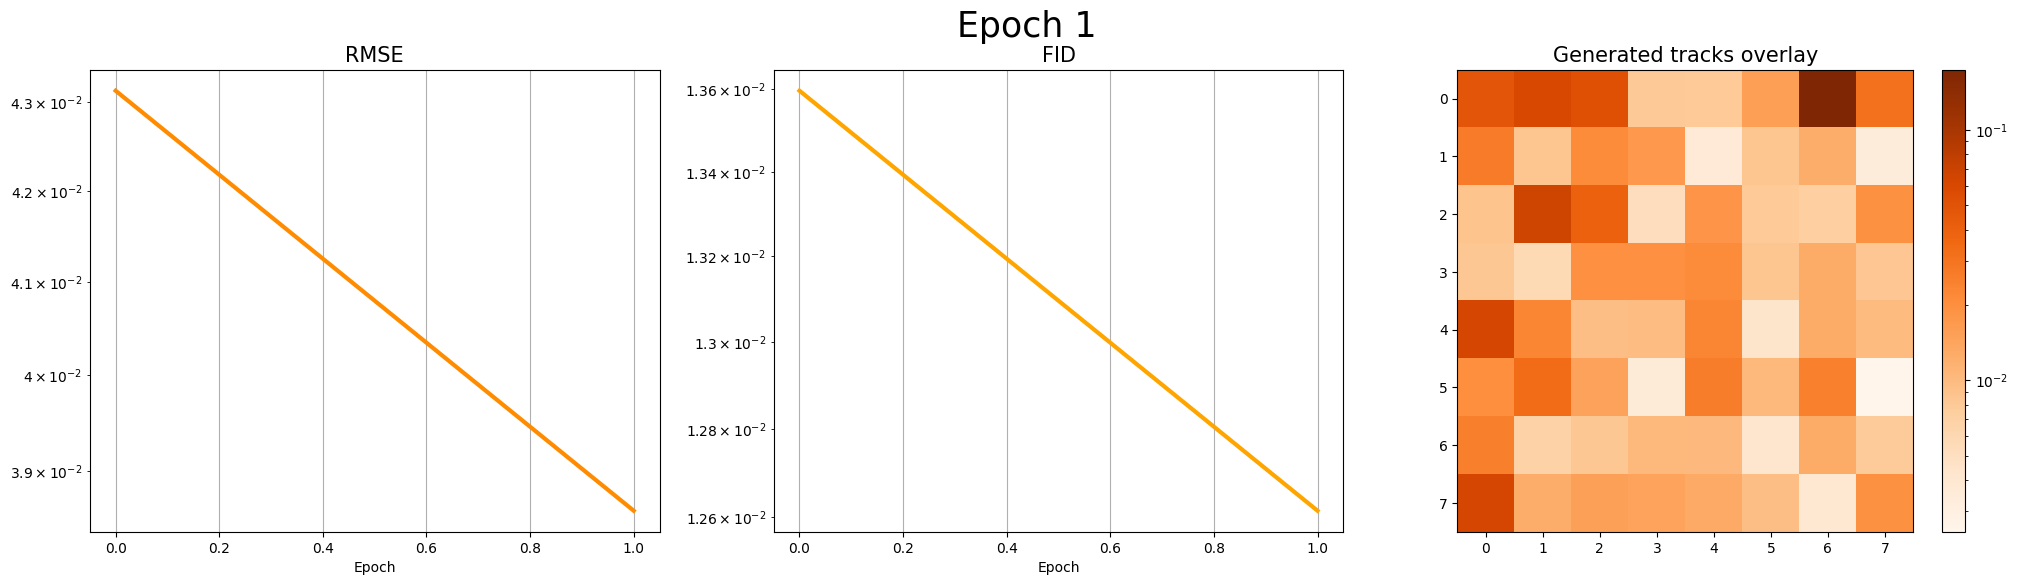

In [18]:
while counter < n_epochs:

    noise = torch.rand(num_samples, n_qubits, device=device)* np.pi / 2
    gen_tracks_overlay = np.mean(generator(noise).detach().numpy().reshape(num_samples, 8, 8), axis=0)
    fd = FID(gluon_tracks_overlay, gen_tracks_overlay)
    rms = np.sqrt(np.mean((gluon_tracks_overlay - gen_tracks_overlay) ** 2))
    #test_images = generator(fixed_noise).view(8,1,8,8).cpu().detach()
    fid.append(fd)
    rel_entr.append(rms)
    epochs.append(counter)

    plot_training_progress()
    
    for i, data in enumerate(dataloader):


        # Data for training the discriminator
        #data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * np.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()
            
    counter += 1
    disc_loss.append(errD)
    gen_loss.append(errG)
    

# **Results**

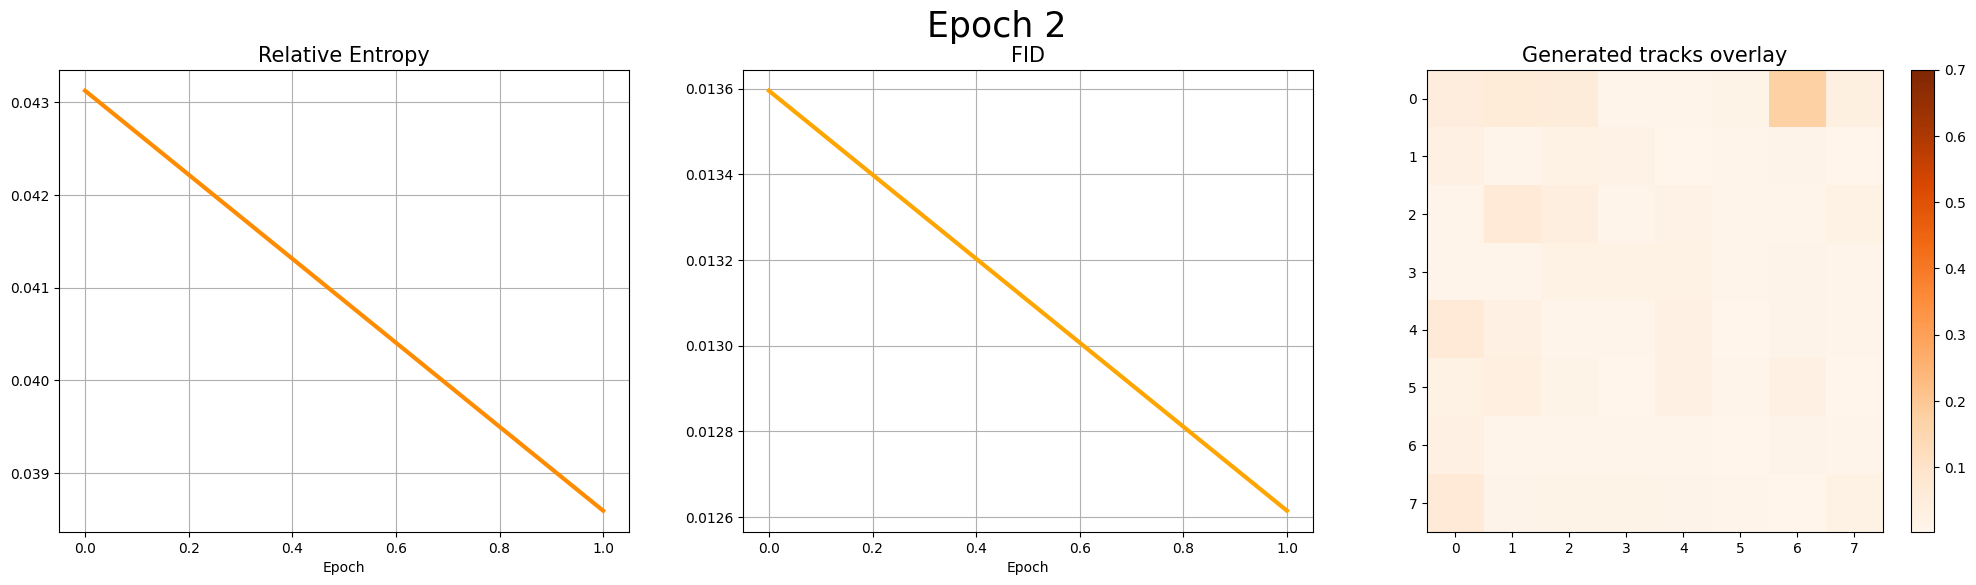

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

# Metric 1
ax1.set_title("Relative Entropy", fontsize=15)
ax1.plot(epochs, rel_entr, color="darkorange", linewidth=3)
ax1.set_xlabel("Epoch")
#ax1.set_yscale("log")
ax1.grid()

# Metric 2
ax2.set_title("FID", fontsize=15)
ax2.plot(epochs, fid, color="orange", linewidth=3)
ax2.set_xlabel("Epoch")
#ax2.set_yscale("log")
ax2.grid()

# Generated distribution
im = ax3.imshow(gen_tracks_overlay, cmap='Oranges', aspect='auto', vmax=0.7)
ax3.set_title('Generated tracks overlay', fontsize=15)

fig.colorbar(im, ax=ax3)

plt.suptitle(f"Epoch {counter}", fontsize=25)
plt.show()

In [20]:
generated_jets = generator(torch.rand(num_samples, n_qubits, device=device) * np.pi / 2).detach().numpy().reshape(num_samples, 8, 8)


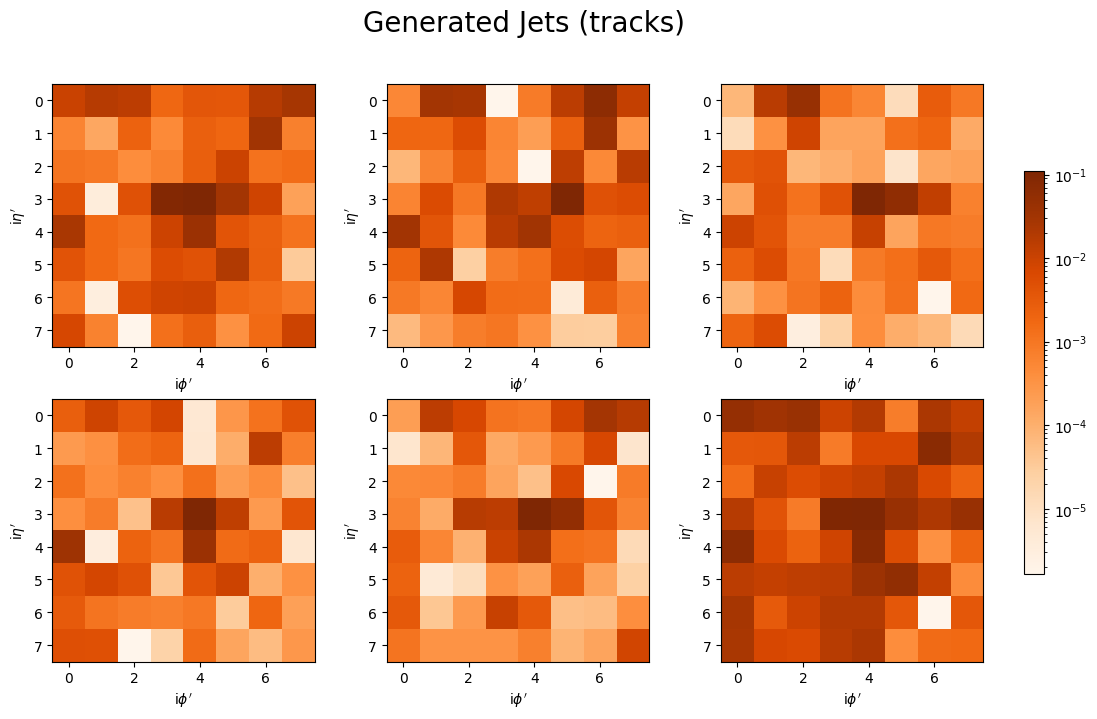

In [21]:

fig, axs = plt.subplots(2, 3, figsize=(13, 7.5)) 

for i, j in product(range(2), range(3)):
    jet = np.random.randint(0, 300)
    im1 = axs[i, j].imshow(generated_jets[jet], cmap="Oranges", norm=mcolors.LogNorm())
    axs[i, j].set_xlabel("Energy Deposits")
    axs[i, j].set_ylabel("jet count")

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.suptitle(f"Generated Jets (tracks)", fontsize=20)
plt.show()

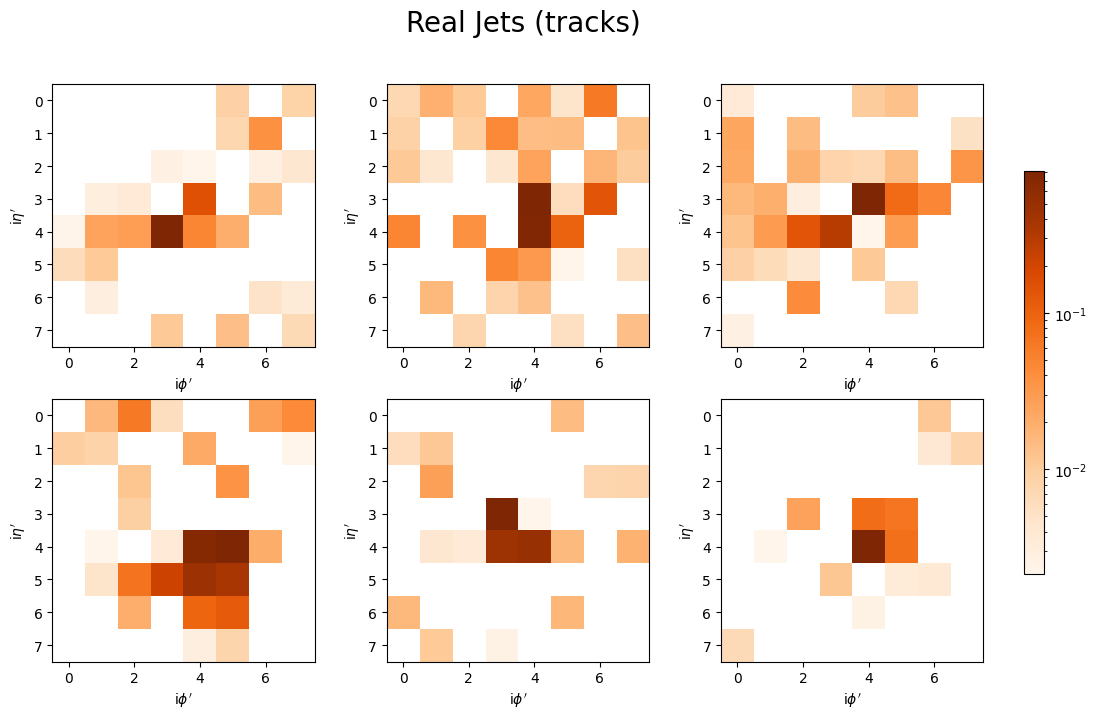

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(13, 7.5)) 

for i, j in product(range(2), range(3)):
    jet = np.random.randint(0, 300)
    im1 = axs[i, j].imshow(all_gluon_8x8[jet], cmap="Oranges", norm=mcolors.LogNorm())
    axs[i, j].set_xlabel("Energy Deposits")
    axs[i, j].set_ylabel("jet count")

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.suptitle(f"Real Jets (tracks)", fontsize=20)
plt.show()

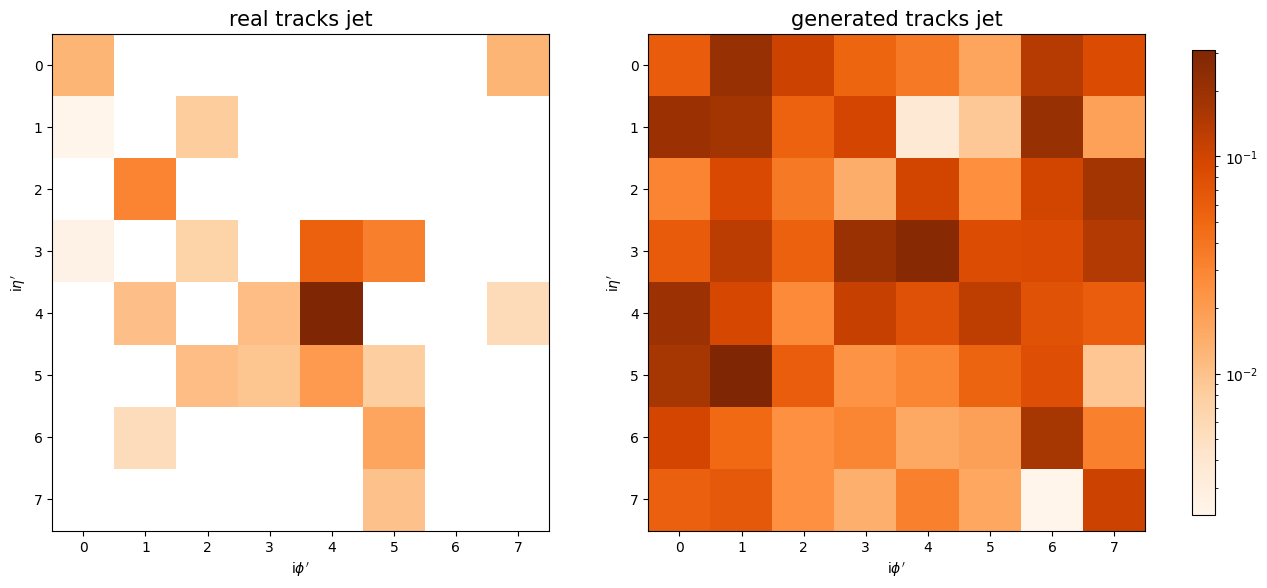

In [23]:
fig, axs =  plt.subplots(1, 2, figsize=(15, 7)) 
n = np.random.randint(0, 500)

im1 = axs[0].imshow(all_gluon_8x8[n], cmap="Oranges", norm=mcolors.LogNorm())
axs[0].set_title("real tracks jet", fontsize=15)

im2 = axs[1].imshow(generated_jets[n], cmap='Oranges', norm=mcolors.LogNorm())
axs[1].set_title("generated tracks jet", fontsize=15)

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

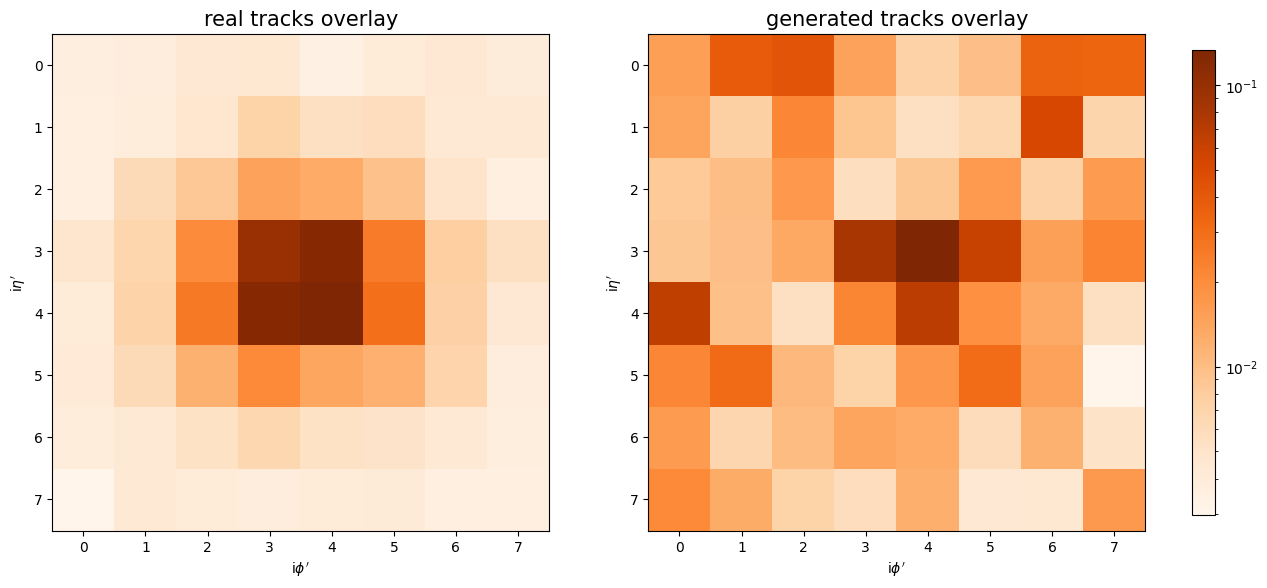

In [24]:
gen_jets_image = np.mean(generated_jets, axis=0)
real_jets_image = np.mean(all_gluon_8x8, axis=0)

fig, axs =  plt.subplots(1, 2, figsize=(15, 7)) 

im1 = axs[0].imshow(real_jets_image, cmap="Oranges", norm=mcolors.LogNorm())
axs[0].set_title("real tracks overlay", fontsize=15)

im2 = axs[1].imshow(gen_jets_image, cmap='Oranges', norm=mcolors.LogNorm())
axs[1].set_title("generated tracks overlay", fontsize=15)

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

In [25]:
gen_total_energy = np.sum(generated_jets, axis=(1,2))


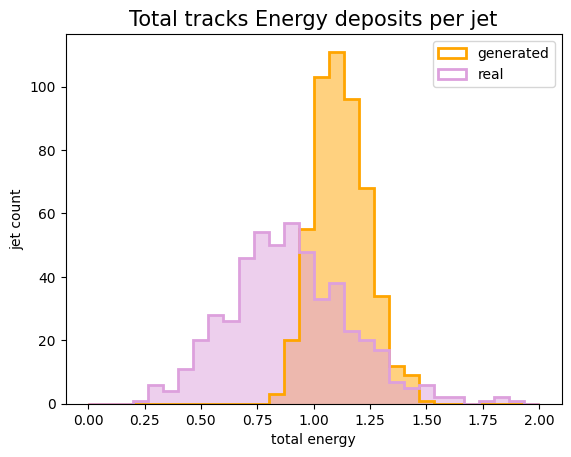

In [26]:
plt.hist(gen_total_energy, range=(0, 2), bins=30, color="orange", label="generated", histtype="step", linewidth=2)
plt.hist(gen_total_energy, range=(0, 2), bins=30, color="orange", alpha=0.5)
plt.hist(total_energy, range=(0, 2), bins=30, color="plum", label="real", histtype="step", linewidth=2)
plt.hist(total_energy, range=(0, 2), bins=30, color="plum", alpha=0.5)
plt.title("Total tracks Energy deposits per jet", fontsize=15)
plt.xlabel("total energy")
plt.ylabel("jet count")
plt.legend()
plt.show()

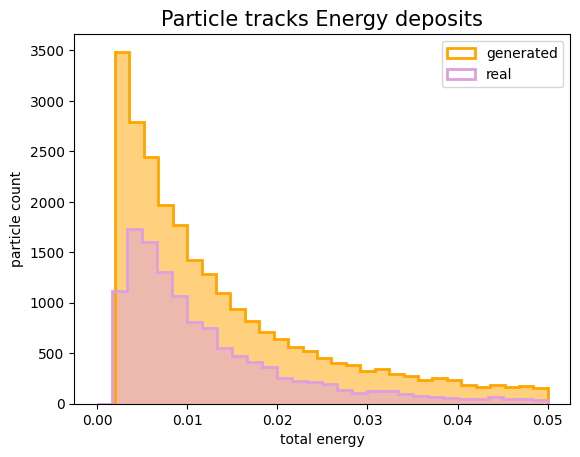

In [27]:
gen_particles_energy_deposits = generated_jets[generated_jets > 0]

plt.hist(gen_particles_energy_deposits, range=(0.002, 0.05), bins=30, color="orange", label="generated", histtype="step", linewidth=2)
plt.hist(gen_particles_energy_deposits, range=(0.002, 0.05), bins=30, color="orange", alpha=0.5)
plt.hist(particles_energy_deposits, range=(0, 0.05), bins=30, color="plum", label="real", histtype="step", linewidth=2)
plt.hist(particles_energy_deposits, range=(0, 0.05), bins=30, color="plum", alpha=0.5)
plt.title("Particle tracks Energy deposits", fontsize=15)
plt.xlabel("total energy")
plt.ylabel("particle count")
plt.legend()
plt.show()

In [28]:
# params = np.stack((generator.q_params[0].detach().numpy(), generator.q_params[1].detach().numpy()))

# with h5py.File('../../data/trained_params/gen_params_test_1.h5', 'w') as file:
#    file.create_dataset('test_1', data=params)